In [243]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from fuzzywuzzy import process

In [244]:
def calculate_bmi(weight_kg, height_m):
    return weight_kg / (height_m ** 2)

def calculate_bmr(age, weight_kg, height_m, gender_F, gender_M):
    if gender_F == 1:  # Female
        return 655 + (9.6 * weight_kg) + (1.8 * height_m * 100) - (4.7 * age)
    elif gender_M == 1:  # Male
        return 66 + (13.7 * weight_kg) + (5 * height_m * 100) - (6.8 * age)
    else:
        raise ValueError("Invalid gender values")

def calculate_macros(weight, height, age, gender, activity_level):
    if gender.lower() == 'male':
        ree = calculate_bmr(age, weight, height, 0, 1)
    elif gender.lower() == 'female':
        ree = calculate_bmr(age, weight, height, 1, 0)

    activity_factors = {
        'sedentary': 1.2,
        'lightly active': 1.375,
        'moderately active': 1.55,
        'very active': 1.725,
        'extra active': 1.9
    }

    tdee = ree * activity_factors[activity_level.lower()]

    # Calculate macros based on percentages
    protein_percent = 0.3
    fat_percent = 0.25
    carb_percent = 1 - protein_percent - fat_percent

    protein_calories = protein_percent * tdee
    fat_calories = fat_percent * tdee
    carb_calories = carb_percent * tdee

    protein_grams = protein_calories / 4  # 1 gram of protein = 4 calories
    fat_grams = fat_calories / 9  # 1 gram of fat = 9 calories
    carb_grams = carb_calories / 4  # 1 gram of carb = 4 calories

    # Calculate water intake recommendation based on activity level
    if activity_level.lower() == 'sedentary':
        water_intake_ml = weight * 30  # 30 ml per kg of body weight per day
    elif activity_level.lower() == 'lightly active':
        water_intake_ml = weight * 35  # 35 ml per kg of body weight per day
    elif activity_level.lower() == 'moderately active':
        water_intake_ml = weight * 40  # 40 ml per kg of body weight per day
    elif activity_level.lower() == 'very active':
        water_intake_ml = weight * 45  # 45 ml per kg of body weight per day
    elif activity_level.lower() == 'extra active':
        water_intake_ml = weight * 50  # 50 ml per kg of body weight per day
    else:
        raise ValueError("Invalid activity level")

    return {
        'TDEE': tdee,
        'protein': protein_grams,
        'fat': fat_grams,
        'carbs': carb_grams,
        'water': water_intake_ml
    }

# Taking user input
weight = float(input("Enter your weight in kg: "))
height = float(input("Enter your height in meters: "))
age = int(input("Enter your age in years: "))
gender = input("Enter your gender (male/female): ")
activity_level = input("Enter your activity level (1)sedentary  2)lightly active 3)moderately active 4)very active 5)extra active): ")

# Calculating BMI
bmi = calculate_bmi(weight, height)
print("Your BMI is:", bmi)
if bmi < 16:
    print("According to your BMI, you are Severely Underweight")
    clbmi = 4
elif 16 <= bmi < 18.5:
    print("According to your BMI, you are Underweight")
    clbmi = 3
elif 18.5 <= bmi < 25:
    print("According to your BMI, you are Healthy")
    clbmi = 2
elif 25 <= bmi < 30:
    print("According to your BMI, you are Overweight")
    clbmi = 1
elif bmi >= 30:
    print("According to your BMI, you are Severely Overweight")
    clbmi = 0

# Calculating BMR and TDEE
if gender.lower() == 'male':
    bmr = calculate_bmr(age, weight, height, 0, 1)
elif gender.lower() == 'female':
    bmr = calculate_bmr(age, weight, height, 1, 0)
else:
    raise ValueError("Invalid gender")

macros = calculate_macros(weight, height, age, gender, activity_level)

print("Your BMR is:", bmr)
print("Your Total Daily Energy Expenditure(TDEE) is:", macros['TDEE'])
print("Recommended Protein intake (g):", macros['protein'])
print("Recommended Fat intake (g):", macros['fat'])
print("Recommended Carbohydrate intake (g):", macros['carbs'])
print("Recommended Water intake (ml):", macros['water'])

Your BMI is: 7.5
According to your BMI, you are Severely Underweight
Your BMR is: 1395.4
Your Total Daily Energy Expenditure(TDEE) is: 1674.48
Recommended Protein intake (g): 125.586
Recommended Fat intake (g): 46.513333333333335
Recommended Carbohydrate intake (g): 188.379
Recommended Water intake (ml): 900.0


In [245]:
food=pd.read_csv('./Dataset/food.csv')
food.head()

,Food_items,Breakfast,Lunch,Dinner,VegNovVeg,Calories,Fats,Proteins,Iron,Calcium,Sodium,Potassium,Carbohydrates,Fibre,VitaminD,Sugars
0,Asparagus Cooked,0,1,1,,22,0.2,2.4,0.91,23.0,14,224.0,4.1,2.0,0,1.3
1,Avocados,1,0,0,0,160,15.0,2.0,0.55,12.0,7,485.0,8.5,6.7,0,0.7
2,Bananas,1,0,0,0,89,0.3,1.1,0.26,5.0,1,358.0,23.0,2.6,0,12.0
3,Bagels made in wheat,0,1,1,0,250,1.5,10.0,2.76,20.0,439,165.0,49.0,4.1,0,6.1
4,Berries,1,0,0,0,349,0.4,14.0,6.80,190.0,298,77.0,77.0,13.0,0,46.0


In [246]:
food.info()
food.describe()
food.isnull().sum()
food.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Food_items     89 non-null     object 
 1   Breakfast      89 non-null     int64  
 2   Lunch          89 non-null     int64  
 3   Dinner         89 non-null     int64  
 4   VegNovVeg      89 non-null     object 
 5   Calories       89 non-null     int64  
 6   Fats           89 non-null     float64
 7   Proteins       89 non-null     float64
 8   Iron           89 non-null     float64
 9   Calcium        89 non-null     float64
 10  Sodium         89 non-null     int64  
 11  Potassium      89 non-null     float64
 12  Carbohydrates  89 non-null     float64
 13  Fibre          89 non-null     float64
 14  VitaminD       89 non-null     int64  
 15  Sugars         89 non-null     float64
dtypes: float64(8), int64(6), object(2)
memory usage: 11.3+ KB


0

In [247]:
food.describe()

,Breakfast,Lunch,Dinner,Calories,Fats,Proteins,Iron,Calcium,Sodium,Potassium,Carbohydrates,Fibre,VitaminD,Sugars
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.471910,0.505618,0.685393,210.314607,8.577528,8.569663,3.709888,64.503371,250.887640,247.803371,26.473034,2.997753,11.516854,8.005056
std,0.502039,0.502801,0.466990,155.350893,11.383888,8.841861,8.554230,112.045798,323.154074,194.792561,25.051777,5.037179,59.071819,16.444337
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,89.000000,0.400000,2.300000,0.500000,8.300000,7.000000,117.000000,7.000000,0.200000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,184.000000,3.700000,4.500000,1.180000,18.000000,80.000000,211.000000,21.000000,1.500000,0.000000,1.300000
75%,1.000000,1.000000,1.000000,318.000000,12.000000,13.000000,2.780000,63.000000,381.000000,334.000000,33.000000,3.100000,0.000000,5.700000
max,1.000000,1.000000,1.000000,579.000000,50.000000,46.000000,57.000000,631.000000,1531.000000,1129.000000,91.000000,34.000000,435.000000,82.000000


In [248]:
# Splitting features (X) and target variable (y)
X = food.drop(['Food_items'], axis=1)  # Features
y = food['Food_items']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (71, 15)
Shape of y_train: (71,)
Shape of X_test: (18, 15)
Shape of y_test: (18,)


<Figure size 1000x800 with 0 Axes>

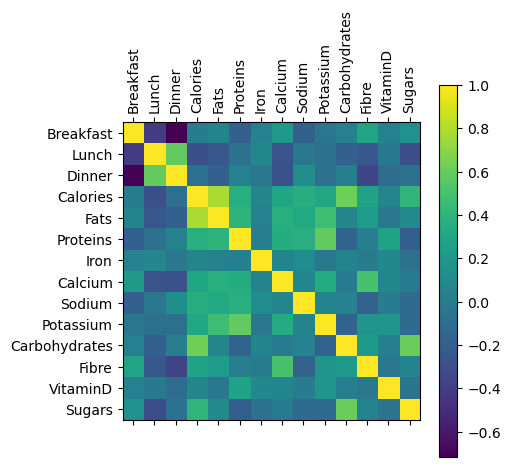

In [249]:
# Select only numeric columns for correlation calculation
numeric_columns = food.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = food[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='viridis')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()


In [250]:
food_items = food['Food_items'].tolist()

for item in food_items:
    print(item)

Asparagus Cooked
Avocados
Bananas
Bagels made in wheat
Berries
Brocolli
Brown Rice
Cauliflower
American cheese
Coffee
Corn
Dark chocolates
Grapes
Milk
Cashew Nuts
Onions
Orange
Pasta canned with tomato sauce
Pears
Peas
Protein Powder
Pumpkin
Tuna Salad
Tuna Fish
Peproni Pizza
Cheese Pizza
French Fries
Chicken Burger
Cheese Burger
Chicken Sandwich
Sugar Doughnuts
Chocolate Doughnuts
Pop Corn - Caramel
Pop Corn
Dosa
Idli
Poha
Chappati
Tomato
Yogurt
Brownie
Noodles
Uttapam
Bhaji Pav
Dal Makhani
Almonds
Mushrooms
Egg Yolk cooked
Sweet Potatoes cooked
Boiled Potatoes
White Rice
Orange juice
Greek yogurt plain
Oat Bran Cooked
Green Tea
Chia seeds
Cottage cheese with vegetables
Salmon
Cereals-Corn Flakes
Beans
Lentils
Pasta with corn homemade
Tea
Apples
Strawberries
Quninoa
Goat meat
Rabbit meat
Chicken Strips
Steak Fries
Mexican Rice
Fried Shrimp
Spaghetti and meatballs
Macroni n Cheese 
Pork cooked
Bacon cooked
Nachos
Chicken Popcorn
Turkey cooked
Oyster cooked
Beef sticks
Banana Chips
Hone

In [251]:
food.head()

,Food_items,Breakfast,Lunch,Dinner,VegNovVeg,Calories,Fats,Proteins,Iron,Calcium,Sodium,Potassium,Carbohydrates,Fibre,VitaminD,Sugars
0,Asparagus Cooked,0,1,1,,22,0.2,2.4,0.91,23.0,14,224.0,4.1,2.0,0,1.3
1,Avocados,1,0,0,0,160,15.0,2.0,0.55,12.0,7,485.0,8.5,6.7,0,0.7
2,Bananas,1,0,0,0,89,0.3,1.1,0.26,5.0,1,358.0,23.0,2.6,0,12.0
3,Bagels made in wheat,0,1,1,0,250,1.5,10.0,2.76,20.0,439,165.0,49.0,4.1,0,6.1
4,Berries,1,0,0,0,349,0.4,14.0,6.80,190.0,298,77.0,77.0,13.0,0,46.0


In [252]:
# Extracting features for each meal
breakfast_data = food[['Breakfast', 'Calories', 'Fats', 'Proteins', 'Iron']]
lunch_data = food[['Lunch', 'Calories', 'Fats', 'Proteins', 'Iron']]
dinner_data = food[['Dinner', 'Calories', 'Fats', 'Proteins', 'Iron']]

# Perform k-means clustering for each meal
kmeans_breakfast = KMeans(n_clusters=2, random_state=42)
kmeans_lunch = KMeans(n_clusters=2, random_state=42)
kmeans_dinner = KMeans(n_clusters=2, random_state=42)

# Fit k-means models
kmeans_breakfast.fit(breakfast_data)
kmeans_lunch.fit(lunch_data)
kmeans_dinner.fit(dinner_data)

# Adding cluster labels to the DataFrame for each meal
food['Breakfast_Cluster'] = kmeans_breakfast.labels_
food['Lunch_Cluster'] = kmeans_lunch.labels_
food['Dinner_Cluster'] = kmeans_dinner.labels_

# Displaying the clusters
print(food[['Breakfast', 'Breakfast_Cluster']])
print(food[['Lunch', 'Lunch_Cluster']])
print(food[['Dinner', 'Dinner_Cluster']])

c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: K

    Breakfast  Breakfast_Cluster
0           0                  1
1           1                  1
2           1                  1
3           0                  0
4           1                  0
..        ...                ...
84          0                  1
85          0                  1
86          0                  0
87          1                  0
88          0                  0

[89 rows x 2 columns]
    Lunch  Lunch_Cluster
0       1              1
1       0              1
2       0              1
3       1              0
4       0              0
..    ...            ...
84      0              1
85      0              1
86      0              0
87      0              0
88      0              0

[89 rows x 2 columns]
    Dinner  Dinner_Cluster
0        1               1
1        0               1
2        0               1
3        1               0
4        0               0
..     ...             ...
84       1               1
85       1               1
86       1     

In [253]:
food.columns

Index(['Food_items', 'Breakfast', 'Lunch', 'Dinner', 'VegNovVeg', 'Calories',
       'Fats', 'Proteins', 'Iron', 'Calcium', 'Sodium', 'Potassium',
       'Carbohydrates', 'Fibre', 'VitaminD', 'Sugars', 'Breakfast_Cluster',
       'Lunch_Cluster', 'Dinner_Cluster'],
      dtype='object')

In [254]:
# Function to find the closest match
def find_closest_match(user_input, column_data):
    choices = column_data.unique()
    closest_match, _ = process.extractOne(user_input, choices)
    return closest_match

# Example user input
user_input_food_item = input("Enter a food item: ")  # Intentional typo to demonstrate fuzzy matching

# Finding closest match
closest_breakfast = find_closest_match(user_input_food_item, food['Food_items'])
closest_lunch = find_closest_match(user_input_food_item, food['Food_items'])
closest_dinner = find_closest_match(user_input_food_item, food['Food_items'])

# Check if the food item is used in breakfast, lunch, or dinner
if closest_breakfast in food['Food_items'].values:
    meal_type = "Breakfast"
elif closest_lunch in food['Food_items'].values:
    meal_type = "Lunch"
elif closest_dinner in food['Food_items'].values:
    meal_type = "Dinner"
else:
    meal_type = "Not found"

print(f"The food item '{user_input_food_item}' is typically used in {meal_type}.")

The food item 'honey' is typically used in Breakfast.


In [255]:
print(food['VegNovVeg'].unique())


[' ' '0' '1']


In [256]:
# Convert 'VegNovVeg' to numerical values (1 for Non-Veg, 0 for Veg)
food['VegNovVeg'] = food['VegNovVeg'].apply(lambda x: 1 if x == 'Non-Veg' else 0)

In [257]:
# Extracting features for clustering
X = food[['VegNovVeg']]

# Perform k-means clustering with 2 clusters (one for vegetarian and one for non-vegetarian)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
food['VegNonVeg_Cluster'] = kmeans.labels_

# Labeling each item as 'Veg' or 'Non-Veg' based on the cluster assigned
food['VegNonVeg'] = food['VegNonVeg_Cluster'].apply(lambda x: 'Non-Veg' if x == 1 else 'Veg')

# Displaying the clusters and identified veg/non-veg items
print(food[['Food_items', 'VegNonVeg']])

c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


              Food_items VegNonVeg
0       Asparagus Cooked       Veg
1               Avocados       Veg
2                Bananas       Veg
3   Bagels made in wheat       Veg
4                Berries       Veg
..                   ...       ...
84     Vanilla Ice cream       Veg
85   Strawberry Icecream       Veg
86          Marshmallows       Veg
87        Chocolate milk       Veg
88          Rice Pudding       Veg

[89 rows x 2 columns]


c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [258]:


# Taking input of a food item
input_food = input("Enter a food item: ")

# Performing fuzzy matching to find the closest match
matched_food = process.extractOne(input_food, food['Food_items'])

# Checking if the matched food item has a high enough similarity score
if matched_food[1] >= 80:  # You can adjust the threshold as needed
    matched_food_name = matched_food[0]
    veg_non_veg = food.loc[food['Food_items'] == matched_food_name, 'VegNonVeg'].values[0]
    print(f"'{input_food}' is  {veg_non_veg}")
else:
    print("No closely matched food item found in the dataset.")


'honey' is  Veg


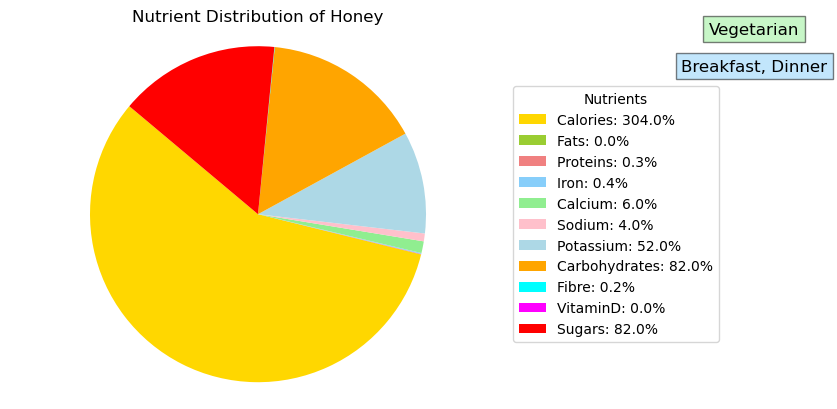

In [259]:

def create_pie_chart(food_df, food_item):
    # Perform fuzzy string matching to find the closest match
    match = process.extractOne(food_item, food_df['Food_items'])
    if match[1] >= 80:  # Adjust the threshold as needed
        food_item = match[0]  # Use the closest match
        item_row = food_df[food_df['Food_items'] == food_item]
        
        # Nutrient labels and sizes
        labels = ['Calories', 'Fats', 'Proteins', 'Iron', 'Calcium', 'Sodium',
                  'Potassium', 'Carbohydrates', 'Fibre', 'VitaminD', 'Sugars']
        sizes = item_row[labels].values[0]
        
        # Colors for the pie chart
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen',
                  'pink', 'lightblue', 'orange', 'cyan', 'magenta', 'red']
        
        # Create pie chart
        fig, ax = plt.subplots()
        wedges, _, _ = ax.pie(sizes, colors=colors, autopct='', startangle=140, textprops=dict(color="black"))
        
        # Add legend next to the pie chart
        ax.legend(wedges, [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)], title="Nutrients", loc="center left", bbox_to_anchor=(1, 0.5))
        
        # Include information about whether the food item is vegetarian or non-vegetarian
        veg_nonveg = item_row['VegNovVeg'].values[0]
        if veg_nonveg == 0:
            veg_label = 'Vegetarian'
        else:
            veg_label = 'Non-Vegetarian'
        plt.text(1.5, 1.0, f'{veg_label}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
        
        # Include information about meal type (breakfast, lunch, or dinner)
        meal_type = ''
        if item_row['Breakfast'].values[0] == 1:
            meal_type += 'Breakfast'
        if item_row['Lunch'].values[0] == 1:
            if meal_type:
                meal_type += ', '
            meal_type += 'Lunch'
        if item_row['Dinner'].values[0] == 1:
            if meal_type:
                meal_type += ', '
            meal_type += 'Dinner'
        plt.text(1.5, 0.9, f'{meal_type}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='lightskyblue', alpha=0.5))
        
        # Equal aspect ratio ensures that pie is drawn as a circle
        ax.axis('equal')  
        
        # Title for the pie chart
        plt.title(f'Nutrient Distribution of {food_item}')
        
        # Show the pie chart
        plt.show()
    else:
        print("Food item not found or not similar enough in the dataset.")

# Call the function with the input
food_item = input("Food Item: ")
create_pie_chart(food, food_item)

In [260]:
df=pd.read_csv("./Dataset/diet.csv")

In [261]:
df.head()

,Meal_Id,Name,catagory,description,Veg_Non,Nutrient,Disease,Diet,Price
0,meal_id1,summer squash salad,salad,"white balsamic vinegar, lemon juice, lemon rin...",veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low...,485
1,meal_id2,chicken minced salad,salad,"olive oil, chicken mince, garlic (minced), oni...",non-veg,fiber,anemia pregnancy hypertension rickets goitre ...,low_fat_diet low_carb_diet ketogenic_diet low...,600
2,meal_id3,sweet chilli almonds,chilli,"almonds whole, egg white, curry leaves, salt, ...",veg,vitamin_a,hypertension scurvy heart_disease goitre kidn...,alkaline_diet low_fat_diet paleo_diet Mediter...,255
3,meal_id4,tricolour salad,salad,"vinegar, honey/sugar, soy sauce, salt, garlic ...",veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet h...,615
4,meal_id5,gluten-free christmas cake,cake,"christmas dry fruits (pre-soaked), orange zest...",veg,vitamin_a,goitre kidney_disease,high_protien_diet,465


In [262]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Meal_Id      512 non-null    object
 1   Name         512 non-null    object
 2   catagory     512 non-null    object
 3   description  511 non-null    object
 4   Veg_Non      512 non-null    object
 5   Nutrient     512 non-null    object
 6   Disease      512 non-null    object
 7   Diet         512 non-null    object
 8   Price        512 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 36.1+ KB


In [263]:
df.shape

(512, 9)

In [264]:
df.isnull().sum()
df.duplicated().sum()

2

In [265]:
df.columns

Index(['Meal_Id', 'Name', 'catagory', 'description', 'Veg_Non', 'Nutrient',
       'Disease', 'Diet', 'Price'],
      dtype='object')

In [266]:
df = df.drop(columns=['Price'])

In [267]:
df.head
df.columns

Index(['Meal_Id', 'Name', 'catagory', 'description', 'Veg_Non', 'Nutrient',
       'Disease', 'Diet'],
      dtype='object')

In [268]:
# Split the data into training and testing sets
X = df.drop(columns=['Veg_Non'])  # Features
y = df['Veg_Non']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of train and test sets
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (409, 7) (409,)
Testing data shape: (103, 7) (103,)


In [269]:
df.head()


,Meal_Id,Name,catagory,description,Veg_Non,Nutrient,Disease,Diet
0,meal_id1,summer squash salad,salad,"white balsamic vinegar, lemon juice, lemon rin...",veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low...
1,meal_id2,chicken minced salad,salad,"olive oil, chicken mince, garlic (minced), oni...",non-veg,fiber,anemia pregnancy hypertension rickets goitre ...,low_fat_diet low_carb_diet ketogenic_diet low...
2,meal_id3,sweet chilli almonds,chilli,"almonds whole, egg white, curry leaves, salt, ...",veg,vitamin_a,hypertension scurvy heart_disease goitre kidn...,alkaline_diet low_fat_diet paleo_diet Mediter...
3,meal_id4,tricolour salad,salad,"vinegar, honey/sugar, soy sauce, salt, garlic ...",veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet h...
4,meal_id5,gluten-free christmas cake,cake,"christmas dry fruits (pre-soaked), orange zest...",veg,vitamin_a,goitre kidney_disease,high_protien_diet


In [270]:
df.nunique()

Meal_Id        309
Name           309
catagory        78
description    327
Veg_Non          2
Nutrient        17
Disease        124
Diet           141
dtype: int64

In [271]:
print("Column Names in DisDif DataFrame:")
print(df.columns)


Column Names in DisDif DataFrame:
Index(['Meal_Id', 'Name', 'catagory', 'description', 'Veg_Non', 'Nutrient',
       'Disease', 'Diet'],
      dtype='object')


In [272]:
food_list2 = df.loc[:, 'Name'].unique().tolist()


In [273]:
print("Food Item List:")
print('-' * 20)  # Separator for better readability

for food_item2 in food_list:
    print(food_item2)

Food Item List:
--------------------
summer squash salad
chicken minced salad
sweet chilli almonds
tricolour salad
gluten-free christmas cake
japanese curry arancini with  barley salsa
chocolate nero cookies
lamb and chargrilled bell pepper soup
cream of almond soup
broccoli and almond soup
coconut lime quinoa salad
lemon honey glazed sous vide corn on the cob
watermelon and strawberry smoothie
peach, raspberry and nuts smoothie
almond and cranberry poha
almond and raw banana galawat
baked namakpara with roasted almond dip
grilled almond barfi (sugar free)
baked shankarpali recipe
baked multigrain murukku
apple rabdi
baked namak para
dates and nuts ladoo
green lentil dessert fudge
cashew nut cookies
almond pearls
hawaiin papaya salad
vegetable som tam salad
spinach and feta crepes
couscous with ratatouille - tangy tomato sauce
baked almond kofta
almond and amaranth ladoo
moong dal kiwi coconut soup
mixed berry &amp; banana smoothie
banana walnut smoothie
spicy watermelon soup
red rice 

In [274]:
df.head()

,Meal_Id,Name,catagory,description,Veg_Non,Nutrient,Disease,Diet
0,meal_id1,summer squash salad,salad,"white balsamic vinegar, lemon juice, lemon rin...",veg,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low...
1,meal_id2,chicken minced salad,salad,"olive oil, chicken mince, garlic (minced), oni...",non-veg,fiber,anemia pregnancy hypertension rickets goitre ...,low_fat_diet low_carb_diet ketogenic_diet low...
2,meal_id3,sweet chilli almonds,chilli,"almonds whole, egg white, curry leaves, salt, ...",veg,vitamin_a,hypertension scurvy heart_disease goitre kidn...,alkaline_diet low_fat_diet paleo_diet Mediter...
3,meal_id4,tricolour salad,salad,"vinegar, honey/sugar, soy sauce, salt, garlic ...",veg,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet h...
4,meal_id5,gluten-free christmas cake,cake,"christmas dry fruits (pre-soaked), orange zest...",veg,vitamin_a,goitre kidney_disease,high_protien_diet


In [275]:
catagory_list = df['catagory'].unique().tolist()
print("Catagory List:")
print('-' * 20)  # Separator for better readability

for type in catagory_list:
    print(type)

Catagory List:
--------------------
salad
chilli
cake
barley
cookie
soup
corn
smoothie
poha
banana
dip
barfi
shankarpali
baked
rabdi
ladoo
dessert
almond
spinach
sauce
kofta
potato
khichdi
snacks
dal
modak
chocolate
gujiya
pizza
cheese
halwa
apple
sangria
tea
margarita
cardamom
milk
coffee
chicken
meat
curry
fish
rice
butter
egg
wine
coriander
kebabs
crab
bread
kheer
kaju
samosa
rabri
coconut
dosa
bao
wrapped
kebab
chop
strawberry
roasted
vanilla
yogurt
pie
pancakes
lamb
gulab
pudding
broccoli
tomato
korma
pakode
berry
bruschetta
tikka
mango
matar


In [276]:
nutrient_list = df['Nutrient'].unique().tolist()

In [277]:
print("Nutrient List:")
print('-' * 20)  # Separator for better readability

for nutri in nutrient_list:
    print(nutri)

Nutrient List:
--------------------
fiber
vitamin_a
calcium
magnesium
sodium
vitamin_c
protien
vitamin_e
iron
selenium
carbohydrates
chloride
potassium
vitamin_d
manganese
phosphorus
iodine


In [278]:
disease_list = df['Disease'].unique().tolist()
print(disease_list)

[' obesity diabeties hypertension goitre', ' anemia pregnancy hypertension rickets goitre kidney_disease obesity', ' hypertension scurvy heart_disease goitre kidney_disease pregnancy', ' obesity goitre hypertension', ' goitre kidney_disease', ' goitre', ' hypertension heart_disease', ' pregnancy scurvy goitre kidney_disease obesity', ' obesity cancer hypertension', ' pregnancy hypertension scurvy obesity diabeties', ' pregnancy hypertension scurvy goitre obesity', ' diabeties goitre scurvy', ' scurvy', ' anemia cancer heart_disease kidney_disease obesity diabeties', ' hypertension', ' anemia hypertension cancer scurvy heart_disease kidney_disease diabeties', ' goitre hypertension kidney_disease', ' goitre hypertension', ' diabeties goitre', ' obesity diabeties', ' anemia hypertension scurvy heart_disease goitre kidney_disease pregnancy diabeties', ' obesity scurvy hypertension goitre', ' hypertension scurvy heart_disease goitre kidney_disease obesity', ' anemia scurvy goitre kidney_dis

In [279]:
unique_disease = []

for diseases_string in disease_list:
    individual_strings = diseases_string.split(', ')
    
    for individual_string in individual_strings:
        diseases_list = individual_string.split()
        
        for diseases in diseases_list:
            disease_names = diseases.split(', ')
            
            if disease_names not in unique_disease :
                unique_disease.append(disease_names)

print(unique_disease)

[['obesity'], ['diabeties'], ['hypertension'], ['goitre'], ['anemia'], ['pregnancy'], ['rickets'], ['kidney_disease'], ['scurvy'], ['heart_disease'], ['cancer'], ['eye_disease']]


In [280]:
print("Disease List:")
print('-' * 20)  # Separator for better readability

for disease in unique_disease:
    print(disease)

Disease List:
--------------------
['obesity']
['diabeties']
['hypertension']
['goitre']
['anemia']
['pregnancy']
['rickets']
['kidney_disease']
['scurvy']
['heart_disease']
['cancer']
['eye_disease']


In [281]:
uni_diseases = [''.join(element).replace('[', '').replace(']', '').replace("'", '') for element in unique_disease]
print(uni_diseases)

['obesity', 'diabeties', 'hypertension', 'goitre', 'anemia', 'pregnancy', 'rickets', 'kidney_disease', 'scurvy', 'heart_disease', 'cancer', 'eye_disease']


In [282]:
for disease in uni_diseases:
    print(disease)

obesity
diabeties
hypertension
goitre
anemia
pregnancy
rickets
kidney_disease
scurvy
heart_disease
cancer
eye_disease


In [283]:
diet_list =df['Diet'].unique().tolist()

In [284]:
unique_diet = []

for types in diet_list:
    diet_types = types.split()
    for diet in diet_types:    
        if diet not in unique_diet :
            unique_diet.append(diet)

print(unique_diet)

['alkaline_diet', 'low_fat_diet', 'ketogenic_diet', 'low_sodium_diet', 'high_fiber_diet', 'high_protien_diet', 'dash_diet', 'low_carb_diet', 'vegan_diet', 'hormone_diet', 'type_a_diet', 'paleo_diet', 'Mediterranean_diet', 'gluten_free_diet', 'omni_diet', 'type_o_diet']


In [285]:
print("Disease List:")
print('-' * 20)  # Separator for better readability

for diet_nm in unique_diet:
    print(diet_nm)

Disease List:
--------------------
alkaline_diet
low_fat_diet
ketogenic_diet
low_sodium_diet
high_fiber_diet
high_protien_diet
dash_diet
low_carb_diet
vegan_diet
hormone_diet
type_a_diet
paleo_diet
Mediterranean_diet
gluten_free_diet
omni_diet
type_o_diet


In [286]:
pip install detect

Note: you may need to restart the kernel to use updated packages.


In [287]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [288]:
pip install googletrans==4.0.0rc1

Note: you may need to restart the kernel to use updated packages.


In [289]:
from langdetect import detect
from googletrans import Translator

def translate_description(description):
    if detect(description) != 'en':
        translator = Translator()
        translated = translator.translate(description, src='auto', dest='en')
        return translated.text
    else:
        return description

In [290]:
# Function to get the description of the food item
def get_description(food_item):
    # Check if the food item exists in the DataFrame using fuzzy matching
    matched_food = process.extractOne(food_item, df['Name'])

    # Check if any food item was matched
    if matched_food:
        matched_food_name = matched_food[0]
        score = matched_food[1]

        # Check if the matched food item has a high similarity score
        if score >= 80:  # You can adjust the threshold as needed
            # Get the description of the matched food item
            description = df.loc[df['Name'] == matched_food_name, 'description'].values[0]

            # Check if the description is in English
            if detect(description) != 'en':
                # Translate the description to English
                translated_description = translate_description(description)
                return translated_description
            else:
                return description
        else:
            return "Food item not found in the dataset"
    else:
        return "Food item not found in the dataset"

# Take user input for the food item
user_input = input("Enter a food item: ")
def translate_description(description):
    try:
        translator = Translator()
        translated = translator.translate(description, src='auto', dest='en')
        return translated.text
    except AttributeError as e:
        print("Translation error:", e)
        return None
    except Exception as e:
        print("An unexpected error occurred during translation:", e)
        return None


# Get the description of the user-inputted food item
description = get_description(user_input)
print("Description:", description)

Description: Food item not found in the dataset


In [291]:
import random

In [292]:
df.drop(columns=['Meal_Id'], inplace=True)

In [293]:
df.columns

Index(['Name', 'catagory', 'description', 'Veg_Non', 'Nutrient', 'Disease',
       'Diet'],
      dtype='object')

In [307]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Veg_Non'] = label_encoder.fit_transform(df['Veg_Non'])

# Extract features
X = df[['Veg_Non']]

# Perform k-means clustering
k = 2  # number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels back to the DataFrame
df['Cluster'] = cluster_labels

cluster_names = {0: 'veg', 1: 'non-veg'}
df['Cluster'] = [cluster_names[label] for label in cluster_labels]

# Display the resulting DataFrame with cluster labels
print(df[['Name', 'Veg_Non', 'Cluster']])

c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Gyatri C Gide\anaconda3\envs\goku\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


                           Name  Veg_Non  Cluster
0           summer squash salad        1  non-veg
1          chicken minced salad        0      veg
2          sweet chilli almonds        1  non-veg
3               tricolour salad        1  non-veg
4    gluten-free christmas cake        1  non-veg
..                          ...      ...      ...
507                  sunga pork        1  non-veg
508                banana chips        1  non-veg
509                 bhurji- egg        0      veg
510       flattened rice / pohe        1  non-veg
511                 puffed rice        1  non-veg

[512 rows x 3 columns]


In [315]:
def predict_veg_nonveg(food_name):
    # Use fuzzy matching to find the closest match to the provided food_name
    closest_match = process.extractOne(food_name, df['Name'])
    
    # Check if a match is found and if the similarity score is above a certain threshold
    if closest_match and closest_match[1] >= 80:
        # Retrieve the cluster name using the matched food name
        row = df[df['Name'] == closest_match[0]]
        cluster_name = row['Cluster'].iloc[0]
        return f"{food_name} is {cluster_name}"
    else:
        return "Food not found in the dataset or no close match found."

food_name = input("Enter the name of the food: ")
cluster_name = predict_veg_nonveg(food_name)
print(cluster_name)

Lamb and chargrilled bell pepper soup is veg


In [330]:
df.head()

,Name,catagory,description,Veg_Non,Nutrient,Disease,Diet,Cluster
0,summer squash salad,salad,"white balsamic vinegar, lemon juice, lemon rin...",1,fiber,obesity diabeties hypertension goitre,alkaline_diet low_fat_diet ketogenic_diet low...,non-veg
1,chicken minced salad,salad,"olive oil, chicken mince, garlic (minced), oni...",0,fiber,anemia pregnancy hypertension rickets goitre ...,low_fat_diet low_carb_diet ketogenic_diet low...,veg
2,sweet chilli almonds,chilli,"almonds whole, egg white, curry leaves, salt, ...",1,vitamin_a,hypertension scurvy heart_disease goitre kidn...,alkaline_diet low_fat_diet paleo_diet Mediter...,non-veg
3,tricolour salad,salad,"vinegar, honey/sugar, soy sauce, salt, garlic ...",1,fiber,obesity goitre hypertension,low_fat_diet ketogenic_diet low_sodium_diet h...,non-veg
4,gluten-free christmas cake,cake,"christmas dry fruits (pre-soaked), orange zest...",1,vitamin_a,goitre kidney_disease,high_protien_diet,non-veg
